# Loan Default Prediction

SIB(Small Industries Bank) loans money to companies in exchange for the promise of repayment.  Some will default on the loans, being unable to repay them for some reason. The bank maintains insurance to reduce their risk of loss in the event of default. The insured amount may cover all or just some part of the loan amount.  SIB wants to predict which companies will default on their loans based on their financial information. They have provided you with a dataset that consists of loan related information such as loan amount, term, and state. Also, there is company information such as the number of employees, operating sector, etc.
 
Using machine learning, predict which companies will default on their loans and explain how different features impact the predictions.

## Problem

Analyze the given data and learn how different features are related to and affect default_status. With the given data, build a machine learning model which can be used to predict the ‘default_status'.
 
For each record in the test set (test.csv), you must predict the value of the default_status variable. You should submit a CSV file with a header row and one row per test entry. The file (submissions.csv) should have exactly 2 columns:

* id
* default_status

In [9]:
# data manipulation
library(data.table, warn.conflicts = F)
library(dplyr, warn.conflicts = F)

# summarize dataset
library(summarytools, warn.conflicts = F)

# plotting
library(ggplot2, warn.conflicts = F)
library(ggpubr, warn.conflicts = F)

# 1. Load Data

In [10]:
# read and browse data
df <- fread('./data/train.csv', na.strings = '')
head(df)

id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
<int64>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
4050975007,Others,VA,27-Apr-10,34,4,New,0,Rural,N,"$35,000.00","$35,000.00",1
3735095001,Manufacturing,CA,05-Nov-09,107,1,New,0,Rural,N,"$15,000.00","$13,500.00",1
3936555004,Trading,CA,26-Feb-10,84,1,New,0,Rural,Y,"$265,000.00","$100,000.00",0
4130405000,Engineering,MI,10-Jun-10,240,21,New,0,Rural,N,"$255,000.00","$255,000.00",0
4263615008,Education,NH,23-Sep-10,36,1,Existing,0,Rural,N,"$13,300.00","$6,650.00",0
3822885000,Administration,VA,24-Dec-09,60,42,New,0,Rural,Y,"$40,000.00","$20,000.00",0


# 2. preliminary data cleaning

* observe 2 fields of amount, which should be numeric. Removing $, character and convert to numeric
* change request date from character to date format


In [11]:
# change data types
clean_data <- function(df){
    df %>%
        mutate(
            request_date = as.Date(request_date, format = '%d-%B-%y'),
            loan_amount = as.numeric(gsub('[$,]','', loan_amount)),
            insured_amount = as.numeric(gsub('[$,]','', insured_amount)))
}
df <- clean_data(df)
head(df)

id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
<int64>,<chr>,<chr>,<date>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>
4050975007,Others,VA,2010-04-27,34,4,New,0,Rural,N,35000,35000,1
3735095001,Manufacturing,CA,2009-11-05,107,1,New,0,Rural,N,15000,13500,1
3936555004,Trading,CA,2010-02-26,84,1,New,0,Rural,Y,265000,100000,0
4130405000,Engineering,MI,2010-06-10,240,21,New,0,Rural,N,255000,255000,0
4263615008,Education,NH,2010-09-23,36,1,Existing,0,Rural,N,13300,6650,0
3822885000,Administration,VA,2009-12-24,60,42,New,0,Rural,Y,40000,20000,0


# 3. Statistic Summary

In train.csv:
 * there are 2402 records (companys) in total
 * they are from 16 distinct industries
 * they are from 50 different states
 * the duration of data provided is 1 year, request date is from 2009-10-01 to 2010-09-30
 * average term is ~ 87
 * average employee count is ~ 9
 * majority (70%) of companies are new business
 * majority (94.5%) of companies are from type - 0
 * 27.5% of the companies are having other loans
 * average default rate is 32.2%
 
train set is pretty complete, only 1 missing record from industry

In [14]:
# Basic Statistical Summary of Data
dfSummary(df %>% select(-id), valid.col = F, graph.col = F) %>% print()

Data Frame Summary  
dfSummary  
Dimensions: 2402 x 12  
Duplicates: 0  

------------------------------------------------------------------------------------------
No   Variable          Stats / Values                     Freqs (% of Valid)     Missing  
---- ----------------- ---------------------------------- ---------------------- ---------
1    industry          1. Trading                         508 (21.2%)            1        
     [character]       2. Construction                    275 (11.5%)            (0.04%)  
                       3. Consulting                      267 (11.1%)                     
                       4. Hotel                           245 (10.2%)                     
                       5. Manufacturing                   245 (10.2%)                     
                       6. Healthcare                      219 ( 9.1%)                     
                       7. Others                          168 ( 7.0%)                     
                

# 4. Exploratory Data Analysis (EDA)

In [25]:
# define theme
options(repr.plot.width = 2.5, repr.plot.height = 1.5, repr.plot.res = 300)
nb.theme <- theme(
    text = element_text(size = 7), 
    element_line(size = 0.1),  
    legend.key.size = unit(0.4,'cm'),
    panel.background = element_rect(fill = "transparent"), # bg of the panel
    plot.background = element_rect(fill = "transparent"), # bg of the plot
    panel.grid.major = element_blank(), # get rid of major grid
    panel.grid.minor = element_blank(), # get rid of minor grid
    legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
    legend.box.background = element_rect(fill = "transparent", color = NA)) # get rid of legend panel

### 4.1 Term distribution

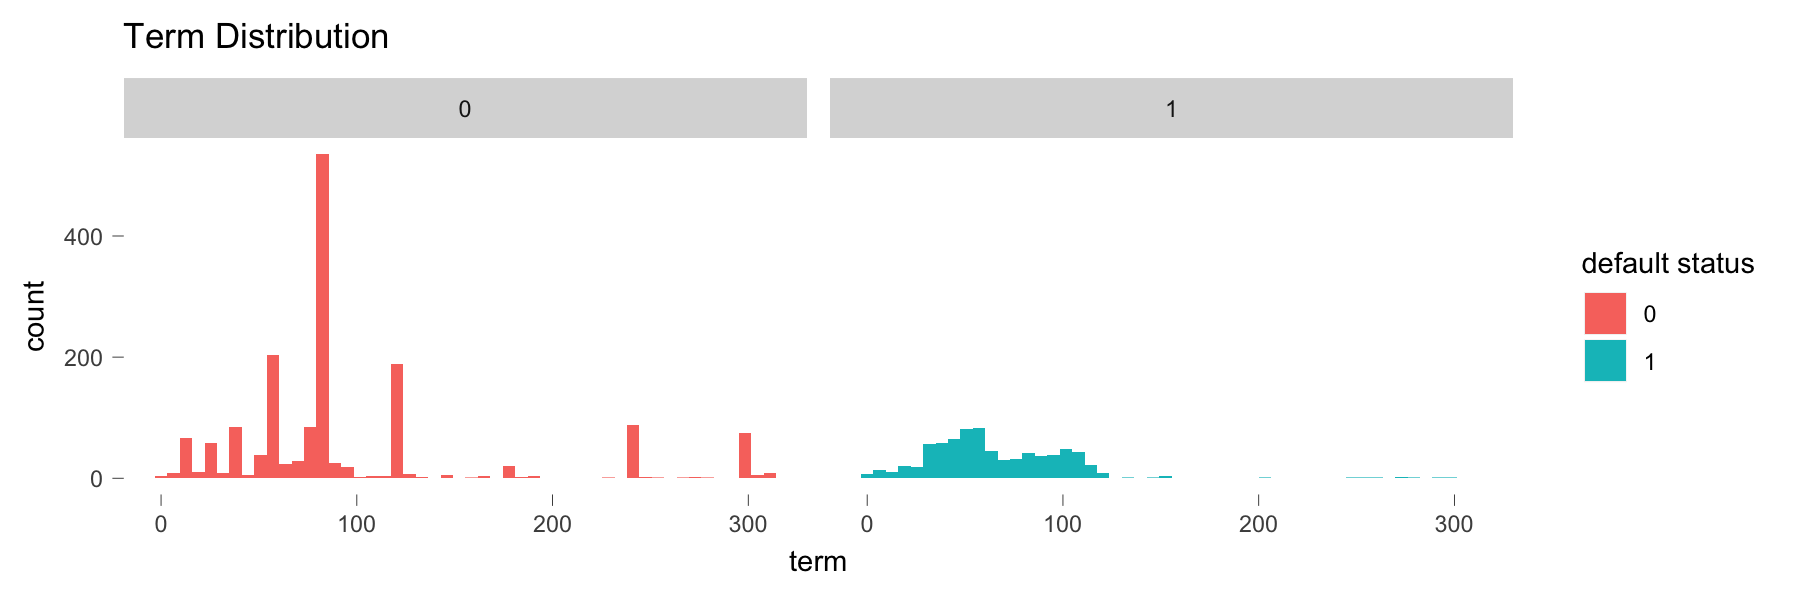

In [26]:
# term historgram
options(repr.plot.width = 6, repr.plot.height = 2, repr.plot.res = 300)
df %>%
ggplot(aes(x = term, fill = factor(default_status))) + 
geom_histogram(bins = 50) + 
facet_grid(~default_status) +
labs(title = 'Term Distribution', fill = 'default status') + 
nb.theme

Compared with non-default loans, the default loans had relatively lower terms.

### 4.2 Loan amount and insured amount distribution

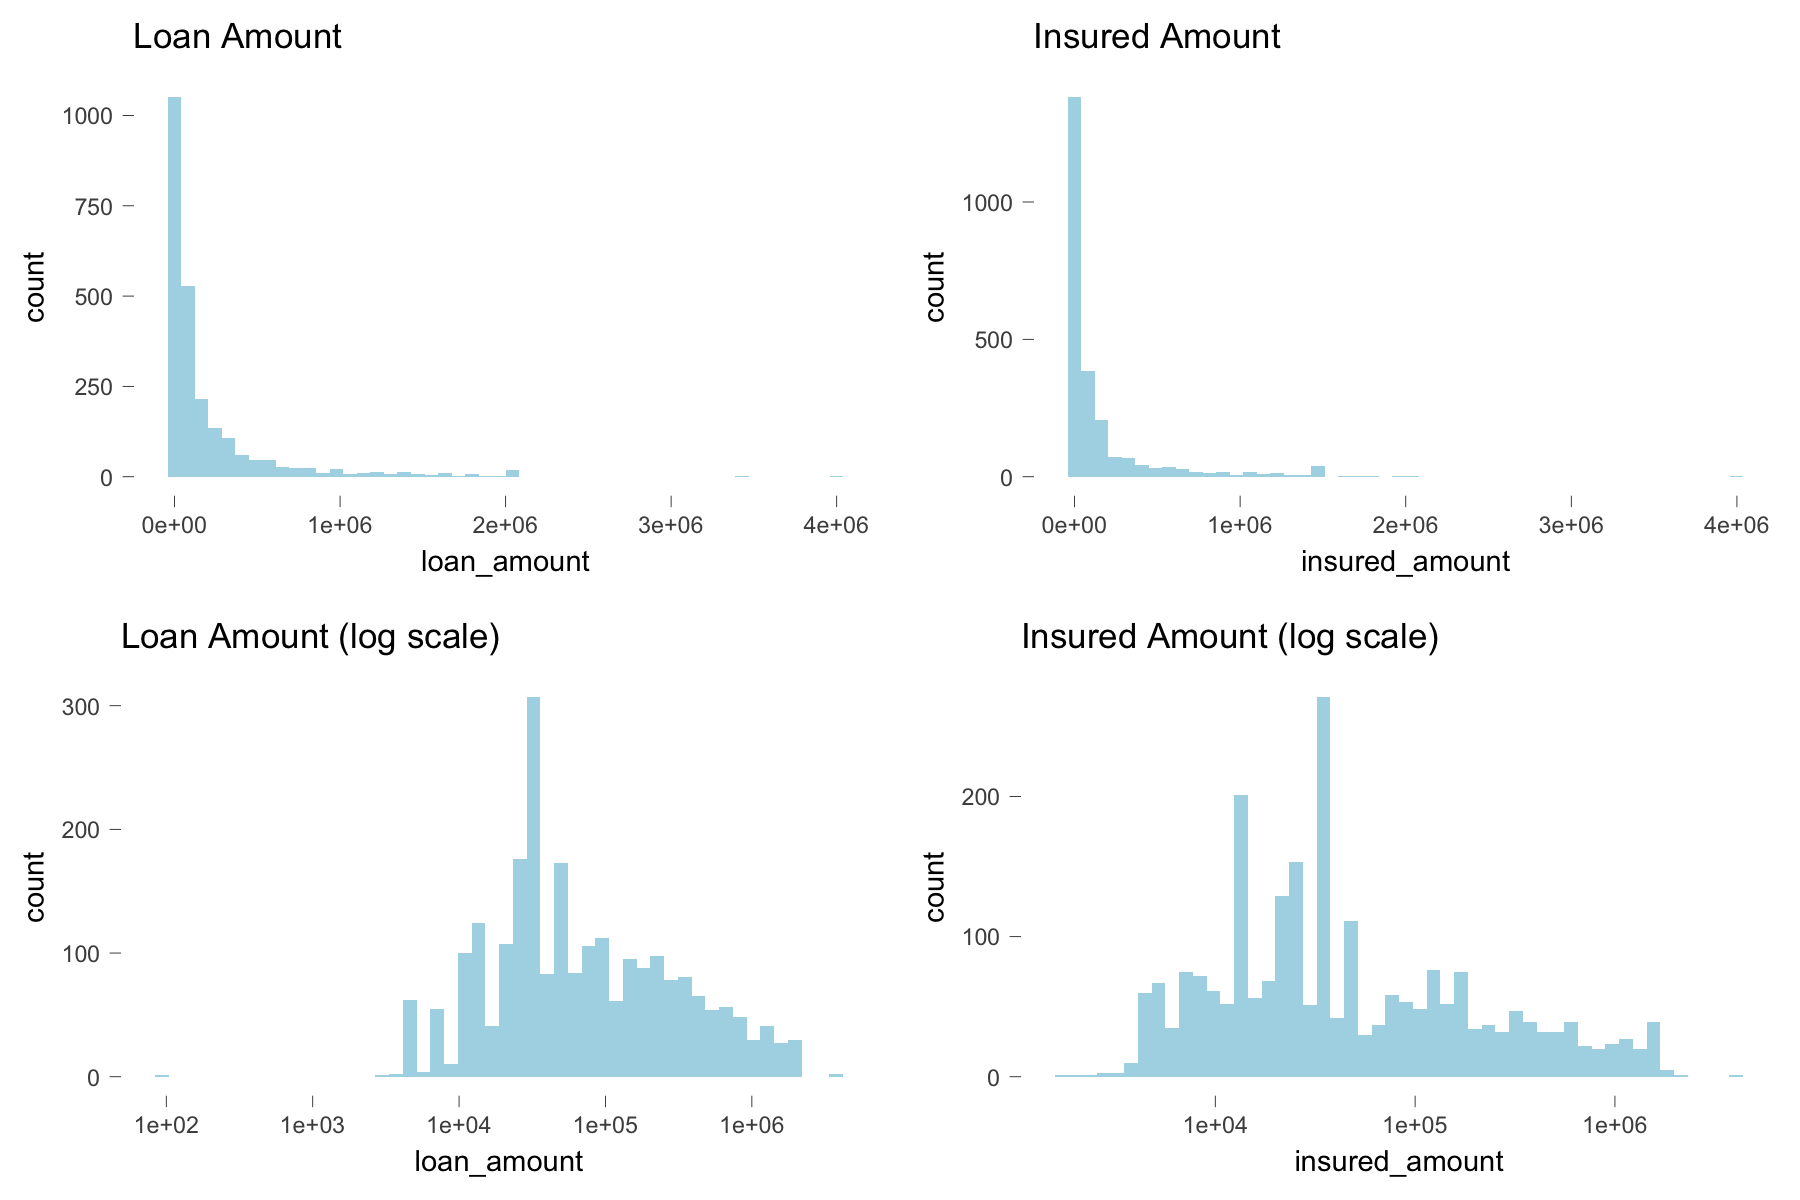

In [28]:
# loan amount and insured amount historgram
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)
p1 <- df %>%
ggplot(aes(x = loan_amount)) + 
geom_histogram(bins = 50, fill = 'lightblue') + 
labs(title = 'Loan Amount') +
nb.theme

p2 <- df %>%
ggplot(aes(x = insured_amount)) + 
geom_histogram(bins = 50, fill = 'lightblue') + 
labs(title = 'Insured Amount') + 
nb.theme

p3 <- p1 + scale_x_log10() + labs(title = 'Loan Amount (log scale)')
p4 <- p2 + scale_x_log10() + labs(title = 'Insured Amount (log scale)')

ggarrange(p1,p2, p3,p4, ncol = 2, nrow = 2, common.legend = T)

Loan amount and Insured amount are both having skewed distribution. Logarithm transformation is applied to bring them to normal-like distribution.

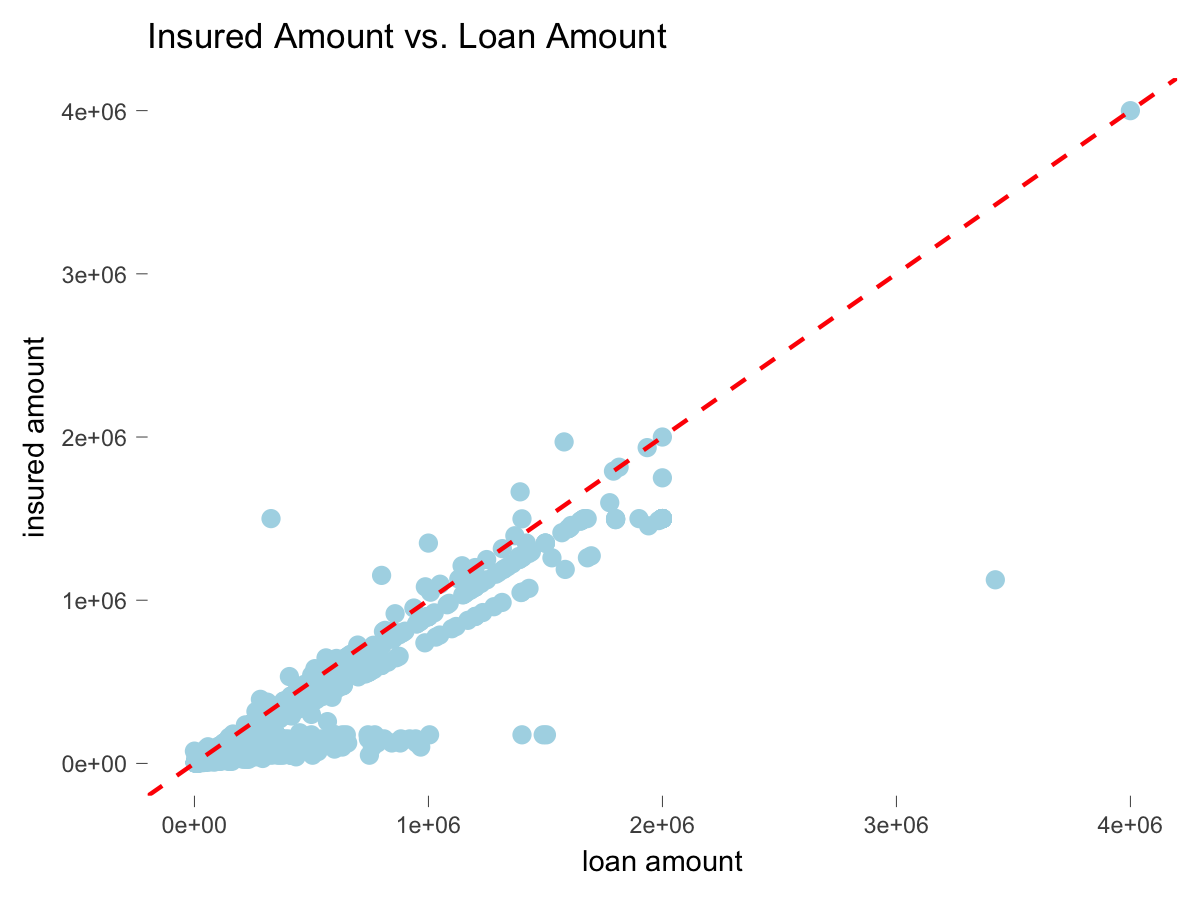

In [35]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 300)
df %>%
ggplot(aes(x = loan_amount, y = insured_amount)) + 
geom_point(color = 'lightblue') +
geom_abline(slope = 1, intercept = 0, color = 'red', linetype = 'dashed') +
labs(title = 'Insured Amount vs. Loan Amount',
     x = 'loan amount',
     y = 'insured amount') +
nb.theme

The insured amount for the default insurance is directly correlated with loan amount of the loan.

### 4.3 Default rate

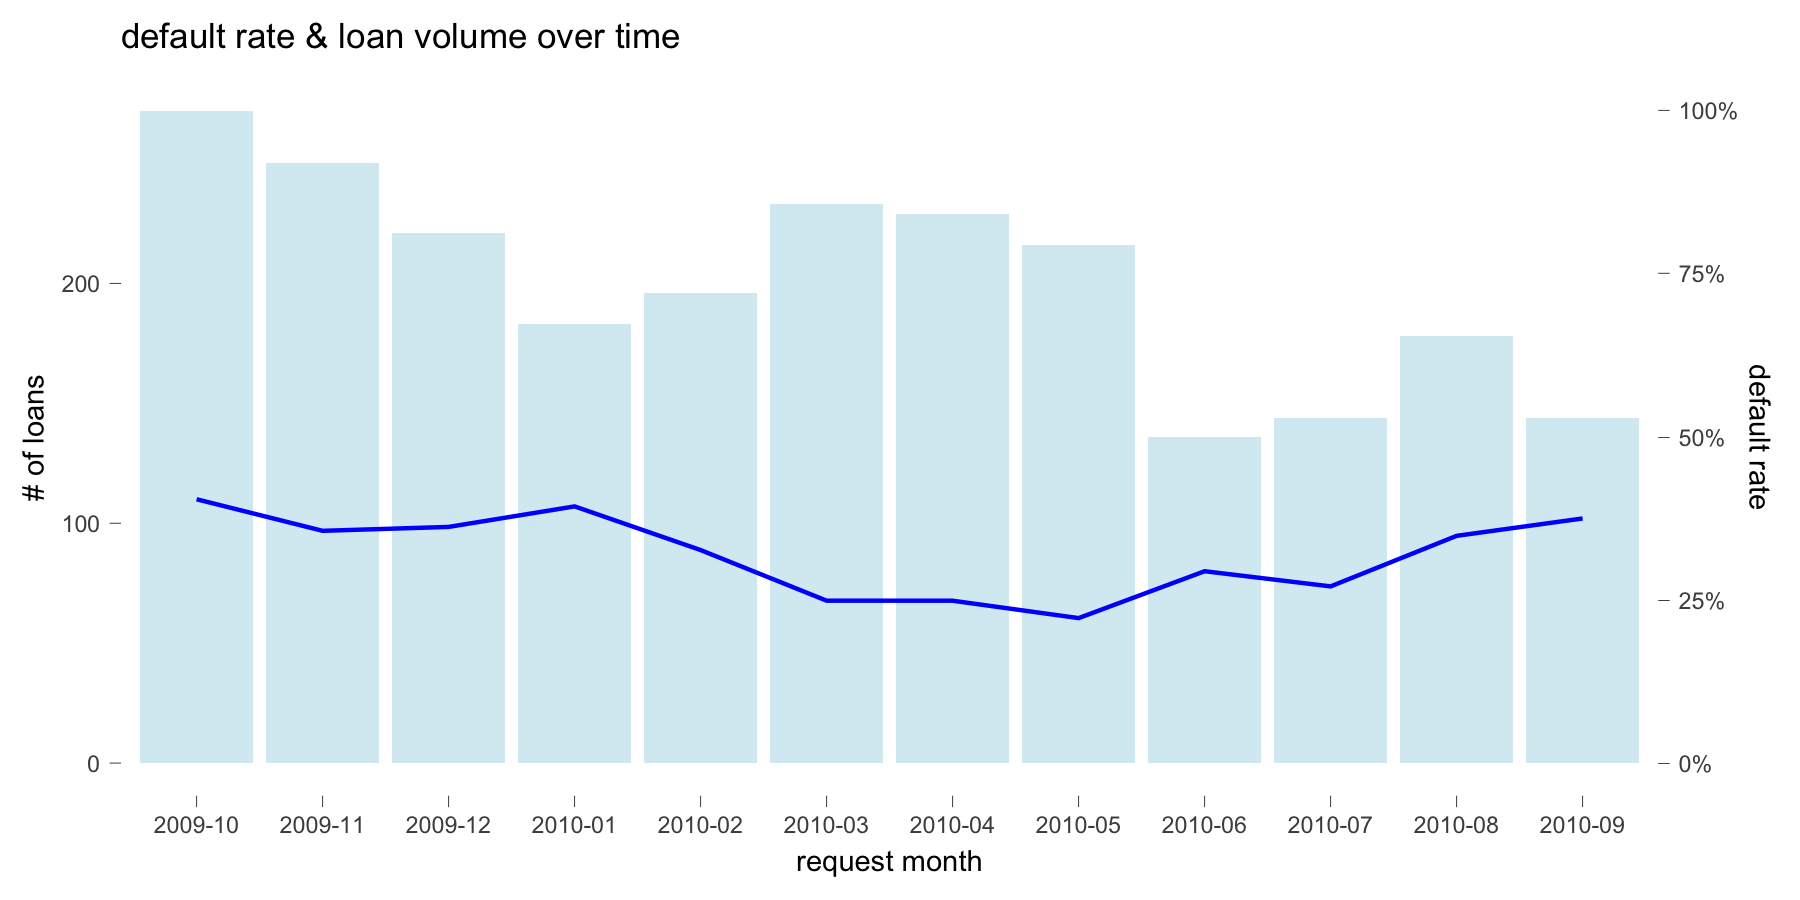

In [52]:
# default rate over time
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 300)
res <- df %>%
mutate(ym = format(request_date, '%Y-%m')) %>%
group_by(ym) %>%
summarise(default_rate = mean(default_status),
          vol = n())
res %>%
ggplot(aes(x = ym, y = vol)) +
geom_bar(stat = 'identity', fill = 'lightblue', alpha = 0.5) +
geom_line(aes(y = default_rate * max(res$vol)), group = 1, color = 'blue') +
scale_y_continuous(sec.axis = sec_axis(~./max(res$vol), 
                                       labels = scales::percent, 
                                       name = 'default rate')) + 
labs(title = 'default rate & loan volume over time', x = 'request month', y = '# of loans') +
nb.theme

* bars represent the volume of loans in each month
* line represents the default rate in each month

The default rate is observed stable from 2019-10 to 2010-09, though the volume of loans showed some variation in months.

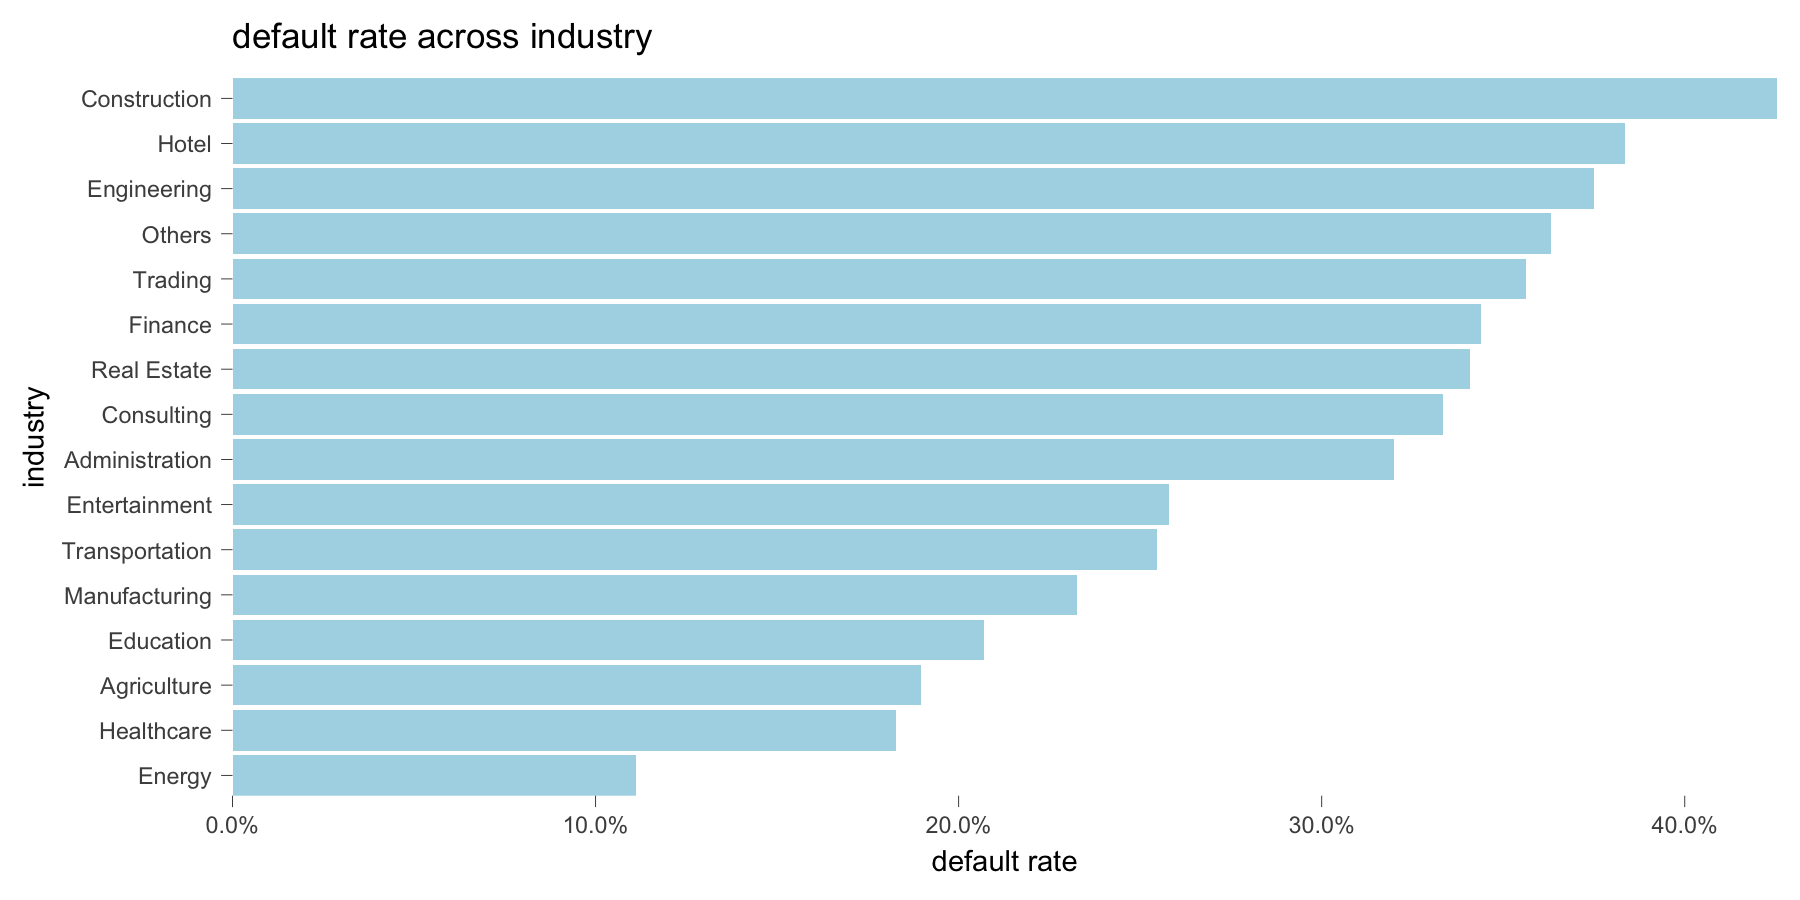

In [57]:
# Industry effect
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 300)
df %>%
filter(!is.na(industry)) %>%
group_by(industry) %>%
summarise(default_rate = mean(default_status)) %>%
ggplot(aes(x = reorder(industry, default_rate), y = default_rate)) +
geom_bar(stat = 'identity', fill = 'lightblue') +
scale_y_continuous(labels = scales::percent) + 
labs(title = 'default rate across industry', x = 'industry', y = 'default rate') +
coord_flip(expand = F) + 
nb.theme

Construction industry has highest default rate, while energy industry has the lowest

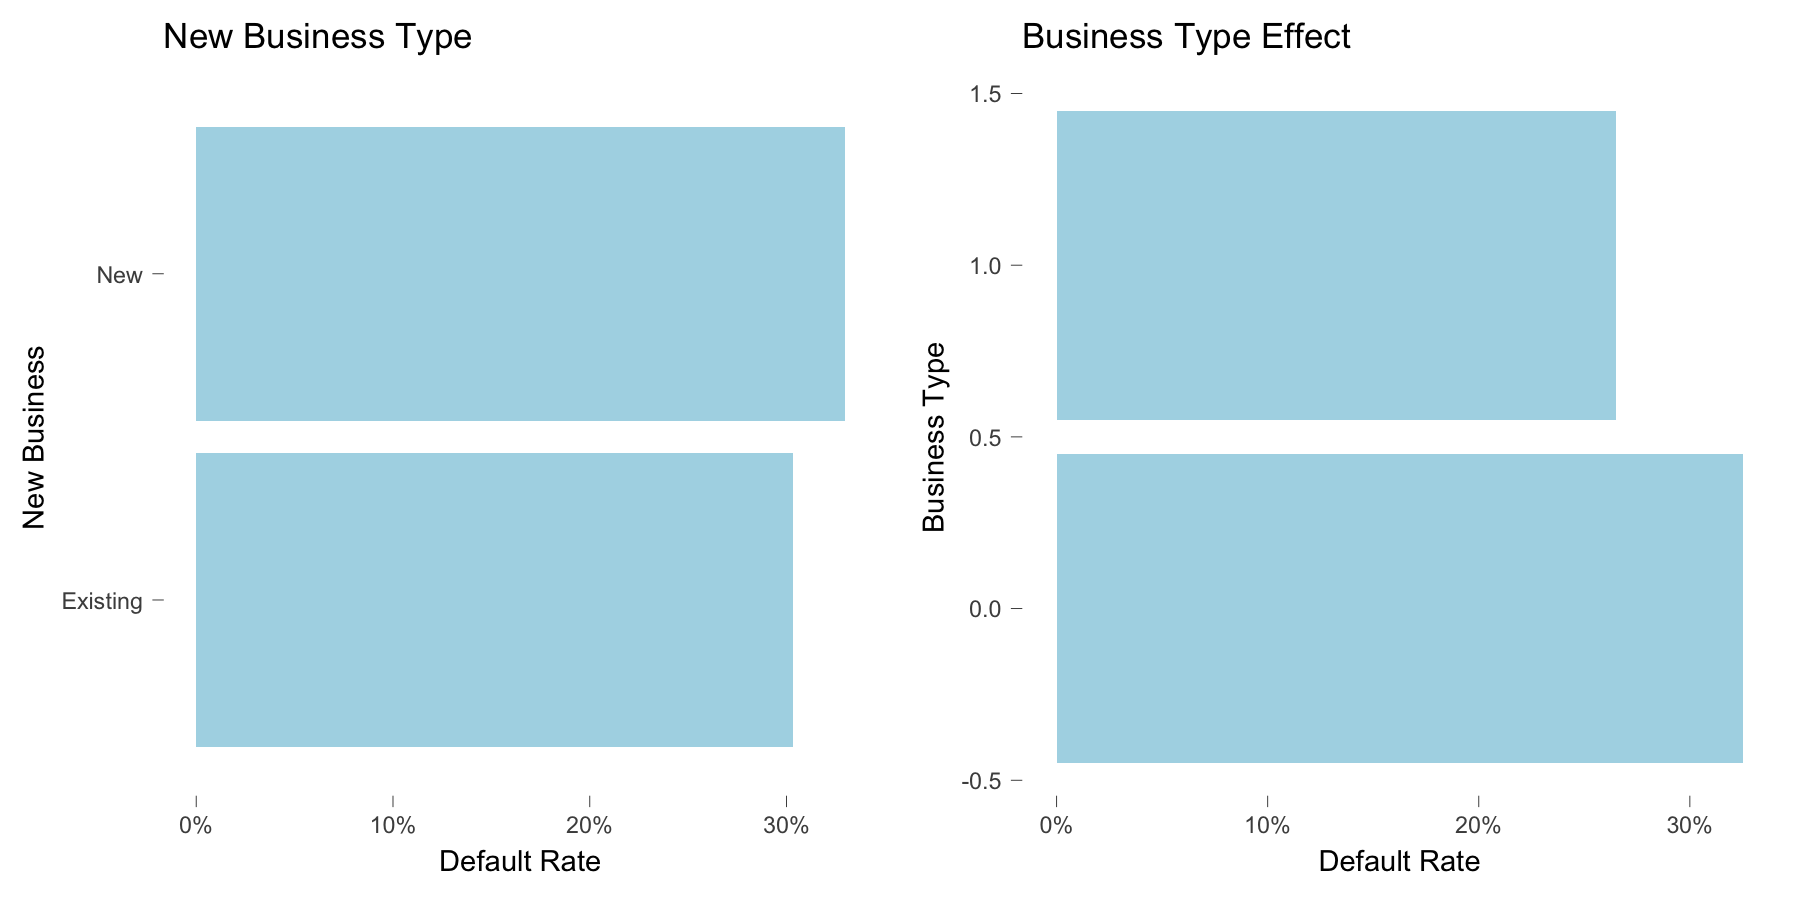

In [58]:
# New business effect
p1 <- df %>%
group_by(business_new) %>%
summarise(default_rate = mean(default_status)) %>%
ggplot(aes(x = business_new, y = default_rate)) +
geom_bar(stat = 'identity', fill = 'lightblue') +
scale_y_continuous(labels = scales::percent) + 
labs(title = 'New Business Type', x = 'New Business', y = 'Default Rate') +
coord_flip() + 
nb.theme

p2 <- df %>%
group_by(business_type) %>%
summarise(default_rate = mean(default_status)) %>%
ggplot(aes(x = business_type, y = default_rate)) +
geom_bar(stat = 'identity', fill = 'lightblue') +
scale_y_continuous(labels = scales::percent) + 
labs(title = 'Business Type Effect', x = 'Business Type', y = 'Default Rate') +
coord_flip() + 
nb.theme

ggarrange(p1,p2, ncol = 2, common.legend = T)

New business tends to have higher default rate

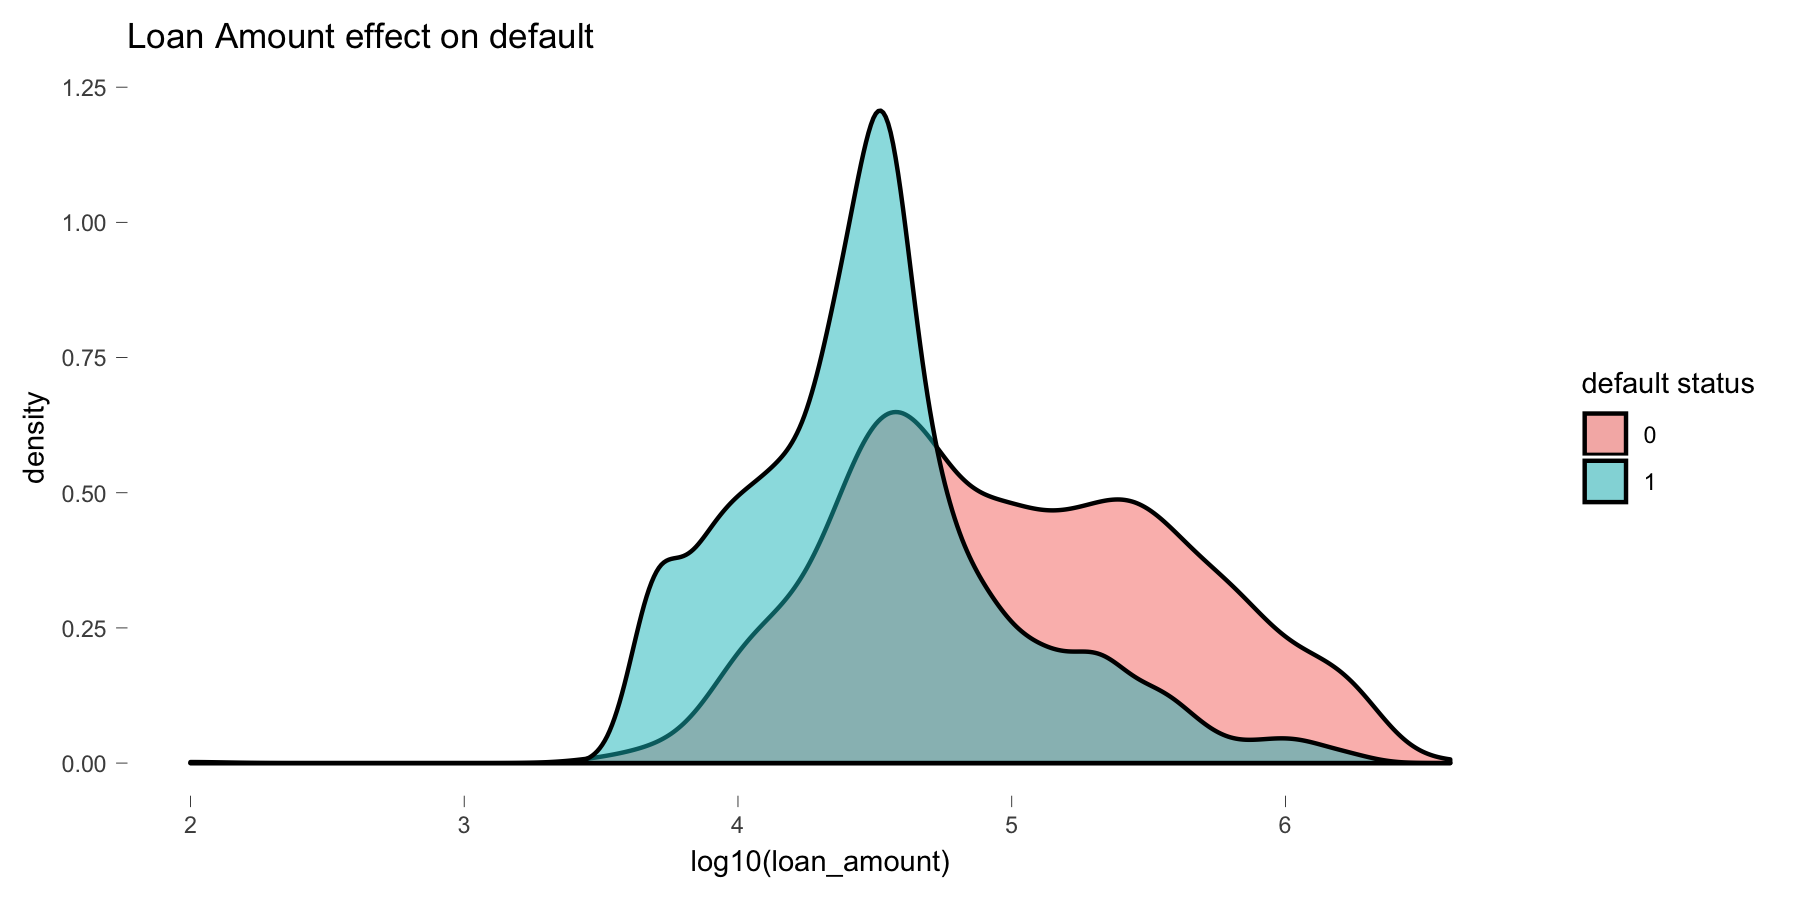

In [61]:
# Loan Amount effect on default
df %>%
ggplot(aes(x = log10(loan_amount), fill = factor(default_status))) +
geom_density(alpha = 0.5) +
labs(title = 'Loan Amount effect on default', fill = 'default status')+
nb.theme

Lower loan amount tends to have high default rate

# 5. Build Predictive Models

In [62]:
library(h2o)
h2o.init(nthreads = 4, max_mem_size = '4g')


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:data.table’:

    hour, month, week, year


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    %*%, %in%, &&, apply, as.factor, as.numeric, colnames, colnames<-,
    ifelse, is.character, is.factor, is.numeric, log, log10, log1p,
    log2, round, signif, trunc, ||





H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/hw/lwpvqtfd115cvnnczqkvh6_80000gn/T//RtmpPdL3Cs/h2o_chaoran_started_from_r.out
    /var/folders/hw/lwpvqtfd115cvnnczqkvh6_80000gn/T//RtmpPdL3Cs/h2o_chaoran_started_from_r.err


Starting H2O JVM and connecting: ... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 500 milliseconds 
    H2O cluster timezone:       Asia/Singapore 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.2 
    H2O cluster version age:    4 months and 10 days !!! 
    H2O cluster name:           H2O_started_from_R_chaoran_vum341 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.56 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:   

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (4 months and 10 days)!
Please download and install the latest version from http://h2o.ai/download/”


In [64]:
# combine train and valid before convert to factor
df$flag <- 'train'
df.test <- fread('./data/test.csv', na.strings = '') %>%
    clean_data() %>%
    mutate(default_status= 0, flag = 'test')
df.full <- rbind(df, df.test)

# create feature from request date
df.full <- df.full %>%
    mutate(request_ym = format(request_date, '%Y-%m'))

# convert data.table to h2o.frame
full.hex <- as.h2o(df.full)

# convert categorical variables to factor
full.hex$label <- h2o.asfactor(full.hex$default_status)
full.hex$industry <- h2o.asfactor(full.hex$industry)
full.hex$state <- h2o.asfactor(full.hex$state)
full.hex$business_new <- h2o.asfactor(full.hex$business_new)
full.hex$other_loans <- h2o.asfactor(full.hex$other_loans)
full.hex$request_ym <- h2o.asfactor(full.hex$request_ym)

# split train, test
train.hex <- full.hex[full.hex$flag == 'train',]
test.hex <- full.hex[full.hex$flag == 'test',]

  |======================================================================| 100%


In [65]:
# define feature set
feature.names <- c('industry',
                   'state', 
                   'term', 
                   'employee_count', 
                   'request_ym',
                   'business_new', 
                   'business_type', 
                   'other_loans',
                   'loan_amount',
                   'insured_amount')

## 5.1 Linear Model - Logistic Regression Baseline

In [66]:
model_ridge <- h2o.glm(x = feature.names, y = 'label', training_frame = train.hex, 
                       family= 'binomial',
                       nfolds = 5, alpha = 0, lambda_search = T)

  |======================================================================| 100%


In [67]:
# auc
h2o.auc(model_ridge, train = T, xval = T)

train      xval 
0.8096337 0.7808646

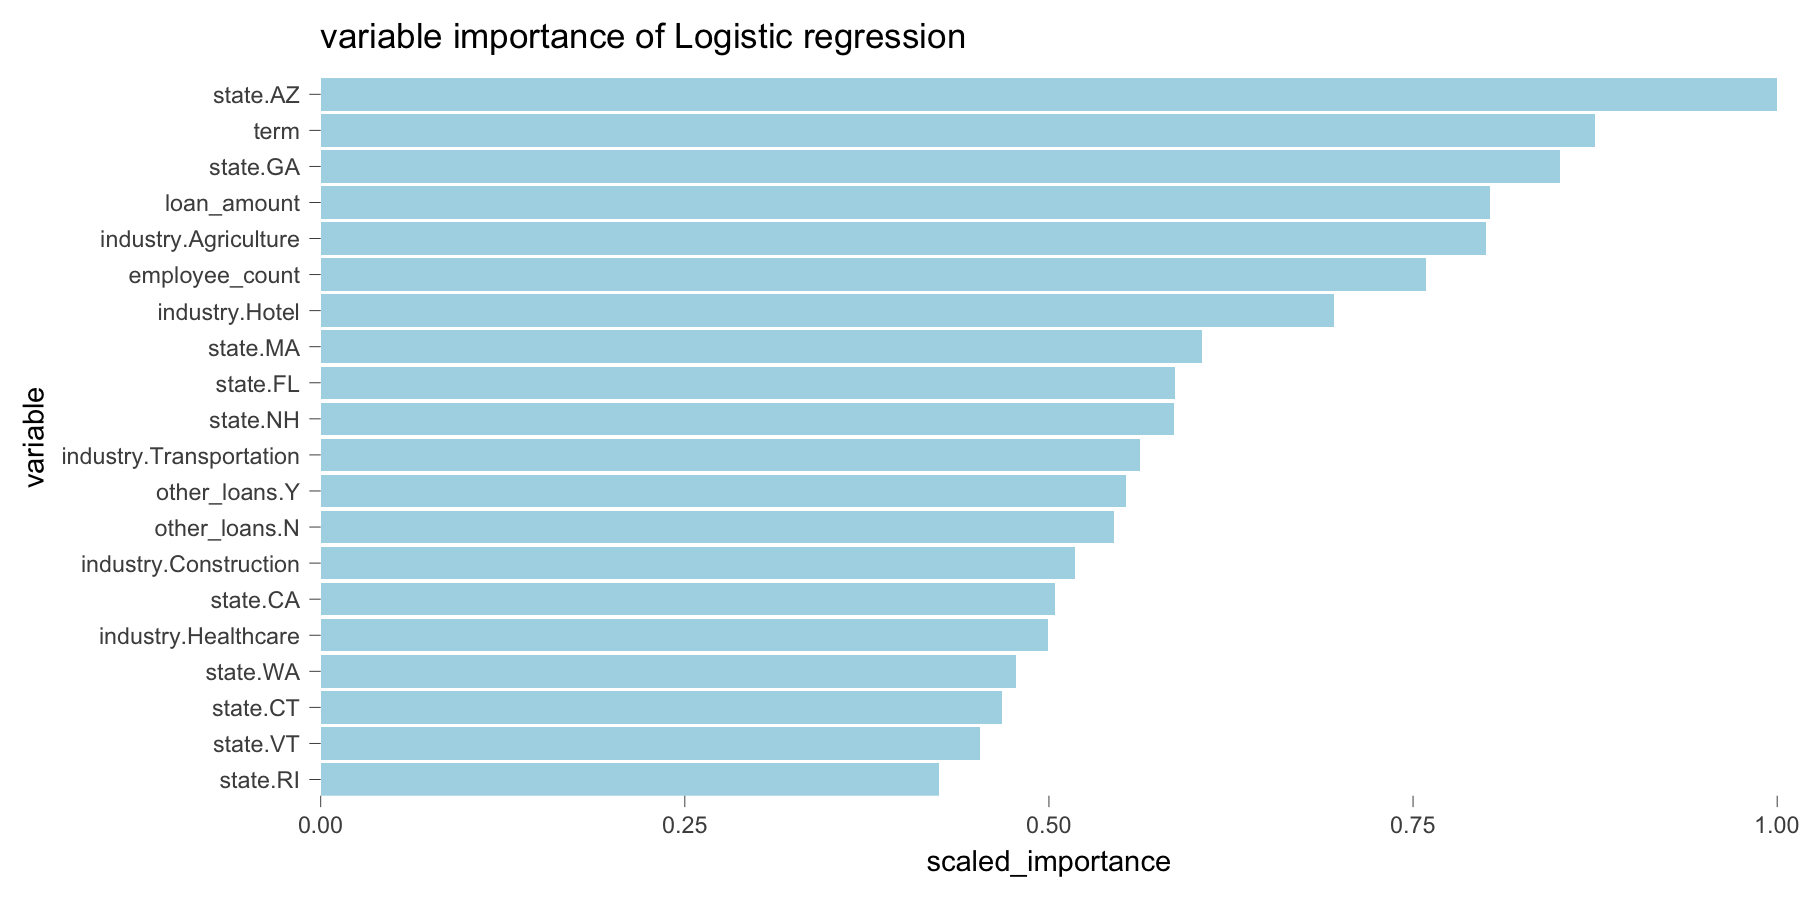

In [73]:
# variable importance
h2o.varimp(model_ridge) %>% 
head(20) %>%
ggplot(aes(x = reorder(variable, scaled_importance), y = scaled_importance)) +
geom_bar(stat = 'identity', fill = 'lightblue') +
coord_flip(expand = F) +
labs(title = 'variable importance of Logistic regression', x = 'variable') +
nb.theme

## 5.2 Xgboost Model - Tree based Ensemble Model

In [74]:
model_xgb <- h2o.xgboost(x = feature.names, y = 'label', training_frame = train.hex, 
                         max_depth = 6, eta = 0.1, 
                         stopping_metric = 'AUC', stopping_rounds = 21, ntrees = 500,
                         nfolds = 5)

  |======================================================================| 100%


In [75]:
# auc
h2o.auc(model_xgb, train = T, xval = T)

train      xval 
0.9999944 0.9565746

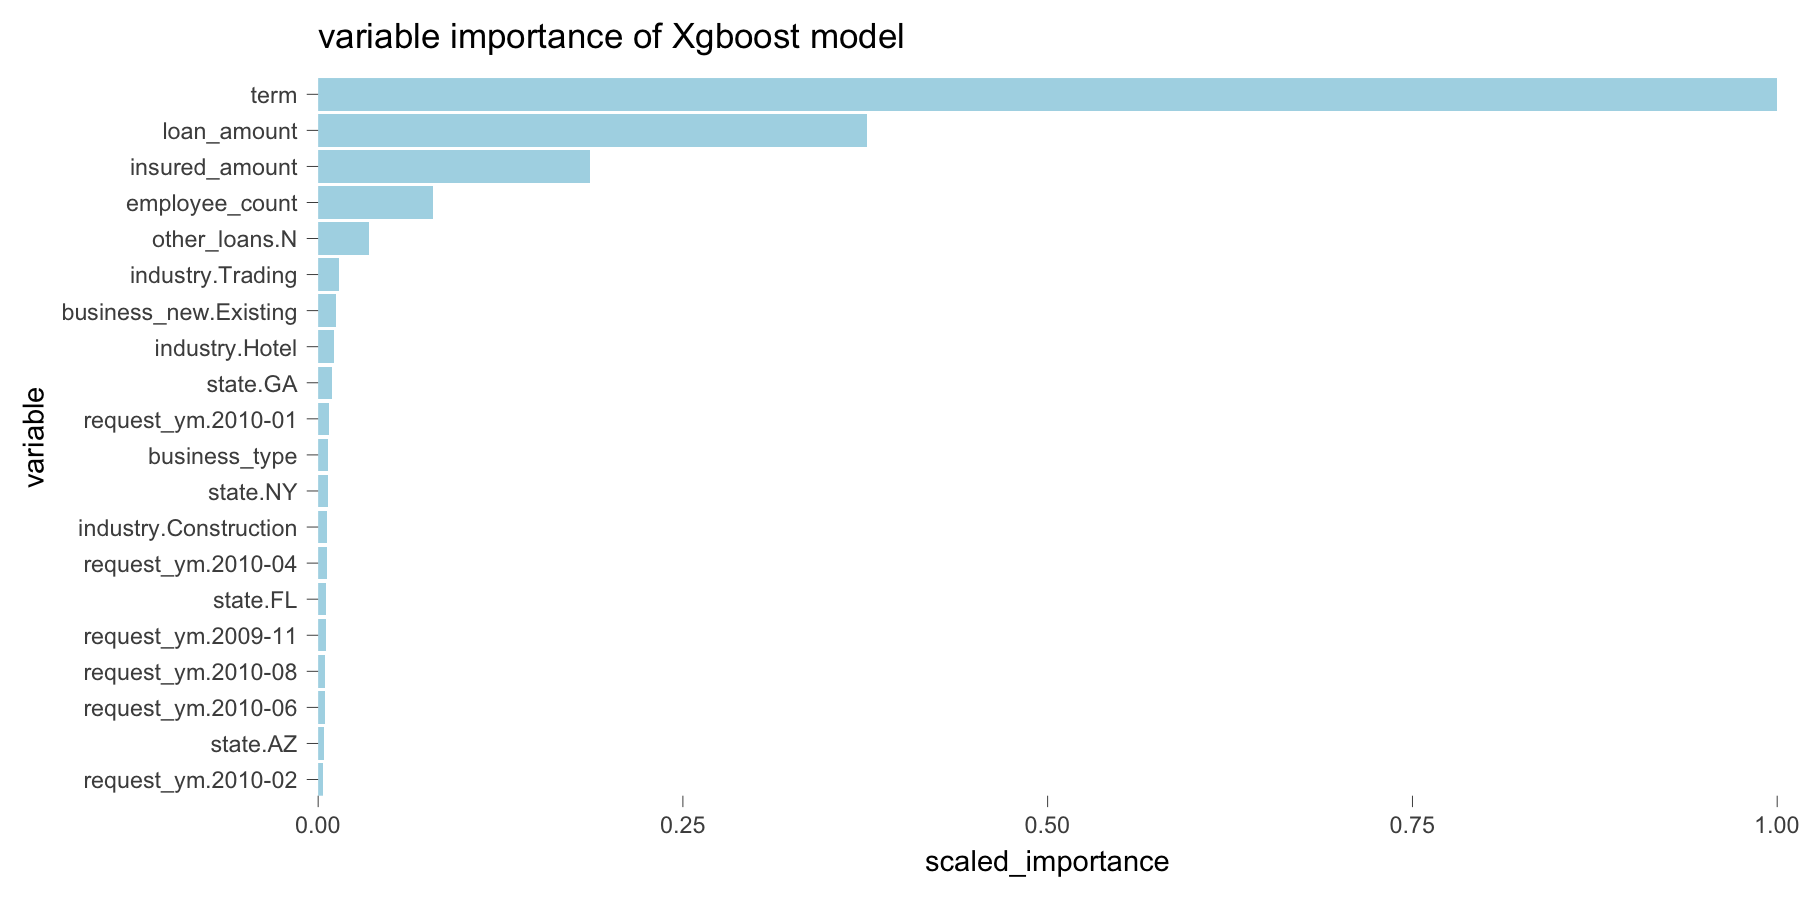

In [78]:
# variable importance
h2o.varimp(model_xgb) %>% 
head(20) %>%
ggplot(aes(x = reorder(variable, scaled_importance), y = scaled_importance)) +
geom_bar(stat = 'identity', fill = 'lightblue') +
coord_flip(expand = F) +
labs(title = 'variable importance of Xgboost model', x = 'variable') +
nb.theme

## 5.3 Model Selection

* Xgboost model is much better than Logistic Regression in terms of AUC. 
* the ranking of top variables in the variable importance for both methods are generally aligned. Term, loan amount and insured amount are the most important variables in predicting the default status for a loan.

Therefore, xgboost model is used for prediction

In [79]:
# make prediction using xgboost
preds <- predict(model_xgb, test.hex)
preds

  |======================================================================| 100%


  predict         p0           p1
1       1 0.41499990 5.850001e-01
2       0 0.99995303 4.698567e-05
3       0 0.99324828 6.751708e-03
4       0 0.76375610 2.362439e-01
5       0 0.99935484 6.451412e-04
6       1 0.01799911 9.820009e-01

[601 rows x 3 columns] 

In [80]:
# add id for prediction
submission <- h2o.cbind(test.hex$id, preds$predict)
submission

          id predict
1 3999155010       1
2 4035035009       0
3 3889475000       0
4 3794845001       0
5 4163475006       0
6 4248455010       1

[601 rows x 2 columns] 

In [81]:
# convert h2o frame to data.frame
submission <- submission %>%
as.data.frame() %>%
rename(default_status = predict)
head(submission)

id,default_status
<dbl>,<fct>
3999155010,1
4035035009,0
3889475000,0
3794845001,0
4163475006,0
4248455010,1


In [82]:
h2o.shutdown(prompt = F)

[1] TRUE